<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Logo-gustave-roussy.jpg/1200px-Logo-gustave-roussy.jpg" alt="Logo 1" width="250"/>
  <img src="https://upload.wikimedia.org/wikipedia/en/thumb/3/3f/Qube_Research_%26_Technologies_Logo.svg/1200px-Qube_Research_%26_Technologies_Logo.svg.png" alt="Logo 2" width="200" style="margin-left: 20px;"/>
</p>

# Data Challenge : Leukemia Risk Prediction


*GOAL OF THE CHALLENGE and WHY IT IS IMPORTANT:*

The goal of the challenge is to **predict disease risk for patients with blood cancer**, in the context of specific subtypes of adult myeloid leukemias.

The risk is measured through the **overall survival** of patients, i.e. the duration of survival from the diagnosis of the blood cancer to the time of death or last follow-up.

Estimating the prognosis of patients is critical for an optimal clinical management. 
For exemple, patients with low risk-disease will be offered supportive care to improve blood counts and quality of life, while patients with high-risk disease will be considered for hematopoietic stem cell transplantion.

The performance metric used in the challenge is the **IPCW-C-Index**.

*THE DATASETS*

The **training set is made of 3,323 patients**.

The **test set is made of 1,193 patients**.

For each patient, you have acces to CLINICAL data and MOLECULAR data.

The details of the data are as follows:

- OUTCOME:
  * OS_YEARS = Overall survival time in years
  * OS_STATUS = 1 (death) , 0 (alive at the last follow-up)

- CLINICAL DATA, with one line per patient:
  
  * ID = unique identifier per patient
  * CENTER = clinical center
  * BM_BLAST = Bone marrow blasts in % (blasts are abnormal blood cells)
  * WBC = White Blood Cell count in Giga/L 
  * ANC = Absolute Neutrophil count in Giga/L
  * MONOCYTES = Monocyte count in Giga/L
  * HB = Hemoglobin in g/dL
  * PLT = Platelets coutn in Giga/L
  * CYTOGENETICS = A description of the karyotype observed in the blood cells of the patients, measured by a cytogeneticist. Cytogenetics is the science of chromosomes. A karyotype is performed from the blood tumoral cells. The convention for notation is ISCN (https://en.wikipedia.org/wiki/International_System_for_Human_Cytogenomic_Nomenclature). Cytogenetic notation are: https://en.wikipedia.org/wiki/Cytogenetic_notation. Note that a karyotype can be normal or abnornal. The notation 46,XX denotes a normal karyotype in females (23 pairs of chromosomes including 2 chromosomes X) and 46,XY in males (23 pairs of chromosomes inclusing 1 chromosme X and 1 chromsome Y). A common abnormality in the blood cancerous cells might be for exemple a loss of chromosome 7 (monosomy 7, or -7), which is typically asssociated with higher risk disease

- GENE MOLECULAR DATA, with one line per patient per somatic mutation. Mutations are detected from the sequencing of the blood tumoral cells. 
We call somatic (= acquired) mutations the mutations that are found in the tumoral cells but not in other cells of the body.

  * ID = unique identifier per patient
  * CHR START END = position of the mutation on the human genome
  * REF ALT = reference and alternate (=mutant) nucleotide
  * GENE = the affected gene
  * PROTEIN_CHANGE = the consequence of the mutation on the protei that is expressed by a given gene
  * EFFECT = a broad categorization of the mutation consequences on a given gene.
  * VAF = Variant Allele Fraction = it represents the **proportion** of cells with the deleterious mutations. 

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
from sklearn.impute import SimpleImputer
from sksurv.util import Surv

# Clinical Data
df = pd.read_csv("X_train/clinical_train.csv")
df_eval = pd.read_csv("X_test/clinical_test.csv")

# Molecular Data
maf_df = pd.read_csv("X_train/molecular_train.csv")
maf_eval = pd.read_csv("X_test/molecular_test.csv")

target_df = pd.read_csv("./target_train.csv")
# target_df_test = pd.read_csv("./target_test.csv")

# Preview the data
df.head()


,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


In [2]:
maf_df.head()

,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH
0,P100000,11,119149248.0,119149248.0,G,A,CBL,p.C419Y,non_synonymous_codon,0.0830,1308.0
1,P100000,5,131822301.0,131822301.0,G,T,IRF1,p.Y164*,stop_gained,0.0220,532.0
2,P100000,3,77694060.0,77694060.0,G,C,ROBO2,p.?,splice_site_variant,0.4100,876.0
3,P100000,4,106164917.0,106164917.0,G,T,TET2,p.R1262L,non_synonymous_codon,0.4300,826.0
4,P100000,2,25468147.0,25468163.0,ACGAAGAGGGGGTGTTC,A,DNMT3A,p.E505fs*141,frameshift_variant,0.0898,942.0


In [3]:
df_visual = df.merge(target_df, on='ID', how='left')

array([[<Axes: xlabel='BM_BLAST', ylabel='BM_BLAST'>,
        <Axes: xlabel='WBC', ylabel='BM_BLAST'>,
        <Axes: xlabel='ANC', ylabel='BM_BLAST'>,
        <Axes: xlabel='MONOCYTES', ylabel='BM_BLAST'>,
        <Axes: xlabel='HB', ylabel='BM_BLAST'>,
        <Axes: xlabel='PLT', ylabel='BM_BLAST'>],
       [<Axes: xlabel='BM_BLAST', ylabel='WBC'>,
        <Axes: xlabel='WBC', ylabel='WBC'>,
        <Axes: xlabel='ANC', ylabel='WBC'>,
        <Axes: xlabel='MONOCYTES', ylabel='WBC'>,
        <Axes: xlabel='HB', ylabel='WBC'>,
        <Axes: xlabel='PLT', ylabel='WBC'>],
       [<Axes: xlabel='BM_BLAST', ylabel='ANC'>,
        <Axes: xlabel='WBC', ylabel='ANC'>,
        <Axes: xlabel='ANC', ylabel='ANC'>,
        <Axes: xlabel='MONOCYTES', ylabel='ANC'>,
        <Axes: xlabel='HB', ylabel='ANC'>,
        <Axes: xlabel='PLT', ylabel='ANC'>],
       [<Axes: xlabel='BM_BLAST', ylabel='MONOCYTES'>,
        <Axes: xlabel='WBC', ylabel='MONOCYTES'>,
        <Axes: xlabel='ANC', ylabel='MON

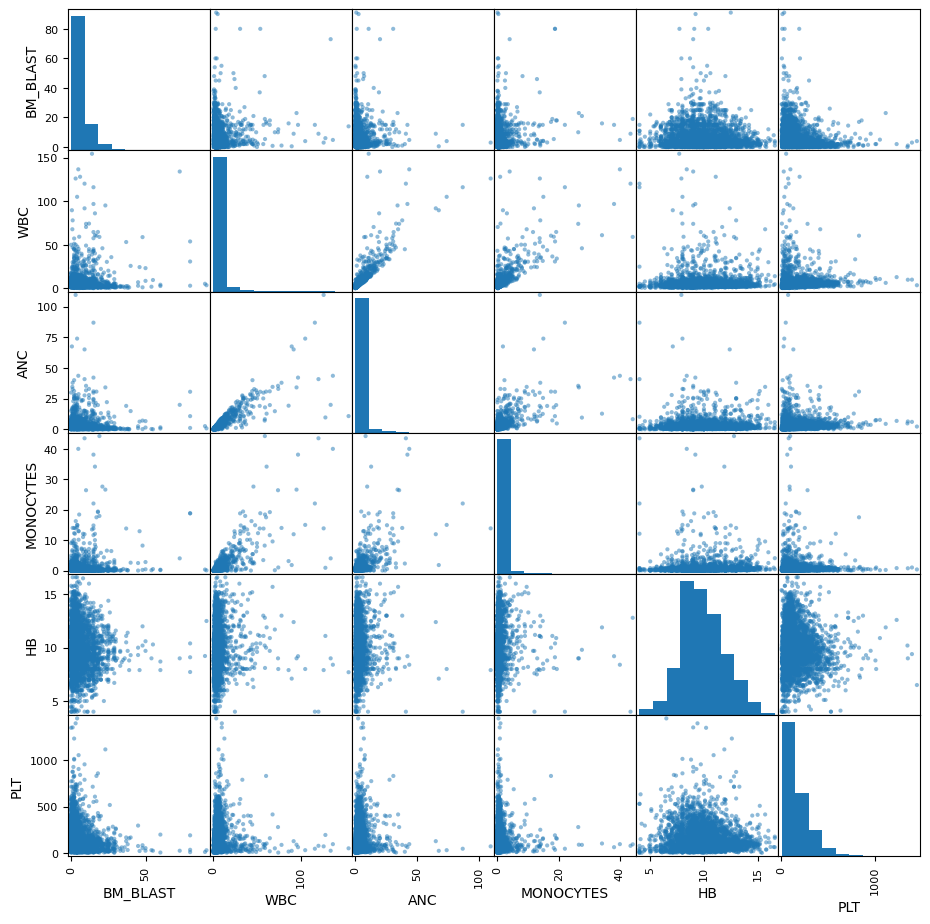

In [4]:
pd.plotting.scatter_matrix(df, figsize=(11, 11))

In [5]:
maf_df.head()

,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH
0,P100000,11,119149248.0,119149248.0,G,A,CBL,p.C419Y,non_synonymous_codon,0.0830,1308.0
1,P100000,5,131822301.0,131822301.0,G,T,IRF1,p.Y164*,stop_gained,0.0220,532.0
2,P100000,3,77694060.0,77694060.0,G,C,ROBO2,p.?,splice_site_variant,0.4100,876.0
3,P100000,4,106164917.0,106164917.0,G,T,TET2,p.R1262L,non_synonymous_codon,0.4300,826.0
4,P100000,2,25468147.0,25468163.0,ACGAAGAGGGGGTGTTC,A,DNMT3A,p.E505fs*141,frameshift_variant,0.0898,942.0


### Step 1: Data Preparation

For survival analysis, we’ll format the dataset so that OS_YEARS represents the time variable and OS_STATUS represents the event indicator.

In [6]:
# Drop rows where 'OS_YEARS' is NaN if conversion caused any issues
target_df.dropna(subset=['OS_YEARS', 'OS_STATUS'], inplace=True)

# Check the data types to ensure 'OS_STATUS' is boolean and 'OS_YEARS' is numeric
print(target_df[['OS_STATUS', 'OS_YEARS']].dtypes)

# Contarget_dfvert 'OS_YEARS' to numeric if it isn’t already
target_df['OS_YEARS'] = pd.to_numeric(target_df['OS_YEARS'], errors='coerce')

OS_STATUS    float64
OS_YEARS     float64
dtype: object


We see that WBC, ANC and Monocytes are positively correlated, we should only use one.

In [7]:
# # Create a column to check if an ID has value 7 

chr7_ids = df[df['CYTOGENETICS'].str.contains(r'-7|del(7)', na=False, regex=True)]['ID'].unique()
chr7_per_id = df[df['ID'].isin(chr7_ids)].groupby('ID').size().reset_index(name='has_chr7')
chr7_per_id_eval = df_eval[df_eval['ID'].isin(chr7_ids)].groupby('ID').size().reset_index(name='has_chr7')

# Merge this information into the main dataframe (df)
df_1 = df.merge(chr7_per_id, on='ID', how='left')
df_1['has_chr7'] = df_1['has_chr7'].fillna(False)
df_1['has_chr7'] = df_1['has_chr7'].astype(int)

df_eval2 = df_eval.merge(chr7_per_id_eval, on='ID', how='left')
df_eval2['has_chr7'] = df_eval2['has_chr7'].fillna(False)
df_eval2['has_chr7'] = df_eval2['has_chr7'].astype(int)


/var/folders/hq/gsdbcm4x4w90mhd9khtb6yzh0000gn/T/ipykernel_81518/1032121378.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  chr7_ids = df[df['CYTOGENETICS'].str.contains(r'-7|del(7)', na=False, regex=True)]['ID'].unique()
/var/folders/hq/gsdbcm4x4w90mhd9khtb6yzh0000gn/T/ipykernel_81518/1032121378.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_eval2['has_chr7'] = df_eval2['has_chr7'].fillna(False)


In [8]:
# Step: Extract the number of somatic mutations per patient
# Group by 'ID' and count the number of mutations (rows) per patient
tmp = maf_df.groupby('ID').size().reset_index(name='Nmut')

# Merge with the training dataset and replace missing values in 'Nmut' with 0
df_2 = df_1.merge(tmp, on='ID', how='left').fillna({'Nmut': 0})

tmp_eval = maf_eval.groupby('ID').size().reset_index(name='Nmut')
df_eval3 = df_eval2.merge(tmp_eval, on='ID', how='left').fillna({'Nmut': 0})

In [9]:
vaf = maf_df.groupby('ID')['VAF'].mean().reset_index()
df_3 = df_2.merge(vaf, on='ID', how='left').fillna({'VAF': 0})

vaf_eval = maf_eval.groupby('ID')['VAF'].mean().reset_index()
df_eval3 = df_eval3.merge(vaf_eval, on='ID', how='left').fillna({'VAF': 0})


In [10]:
# Compute mean START and END per ID from maf_df
mean_start_end_per_id = maf_df.groupby('ID')[['START', 'END']].mean().reset_index()
df_4 = df_3.merge(mean_start_end_per_id, on='ID', how='left')
df_4['EmS'] = df_4['END'] - df_4['START']

mean_start_mean_eval = maf_eval.groupby('ID')[['START', 'END']].mean().reset_index()
df_eval4 = df_eval3.merge(mean_start_mean_eval, on='ID', how='left')
df_eval4['EmS'] = df_eval4['END'] - df_eval4['START']



In [11]:
# Select features
features = ['BM_BLAST', 'WBC', 'HB', 'PLT', 'Nmut', 'has_chr7', 'VAF', 'EmS']
target = ['OS_YEARS', 'OS_STATUS']
    
# Create the survival data format
X = df_4.loc[df_3['ID'].isin(target_df['ID']), features]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

array([[<Axes: xlabel='BM_BLAST', ylabel='BM_BLAST'>,
        <Axes: xlabel='WBC', ylabel='BM_BLAST'>,
        <Axes: xlabel='HB', ylabel='BM_BLAST'>,
        <Axes: xlabel='PLT', ylabel='BM_BLAST'>,
        <Axes: xlabel='Nmut', ylabel='BM_BLAST'>,
        <Axes: xlabel='has_chr7', ylabel='BM_BLAST'>,
        <Axes: xlabel='VAF', ylabel='BM_BLAST'>,
        <Axes: xlabel='EmS', ylabel='BM_BLAST'>],
       [<Axes: xlabel='BM_BLAST', ylabel='WBC'>,
        <Axes: xlabel='WBC', ylabel='WBC'>,
        <Axes: xlabel='HB', ylabel='WBC'>,
        <Axes: xlabel='PLT', ylabel='WBC'>,
        <Axes: xlabel='Nmut', ylabel='WBC'>,
        <Axes: xlabel='has_chr7', ylabel='WBC'>,
        <Axes: xlabel='VAF', ylabel='WBC'>,
        <Axes: xlabel='EmS', ylabel='WBC'>],
       [<Axes: xlabel='BM_BLAST', ylabel='HB'>,
        <Axes: xlabel='WBC', ylabel='HB'>,
        <Axes: xlabel='HB', ylabel='HB'>,
        <Axes: xlabel='PLT', ylabel='HB'>,
        <Axes: xlabel='Nmut', ylabel='HB'>,
        <Axes:

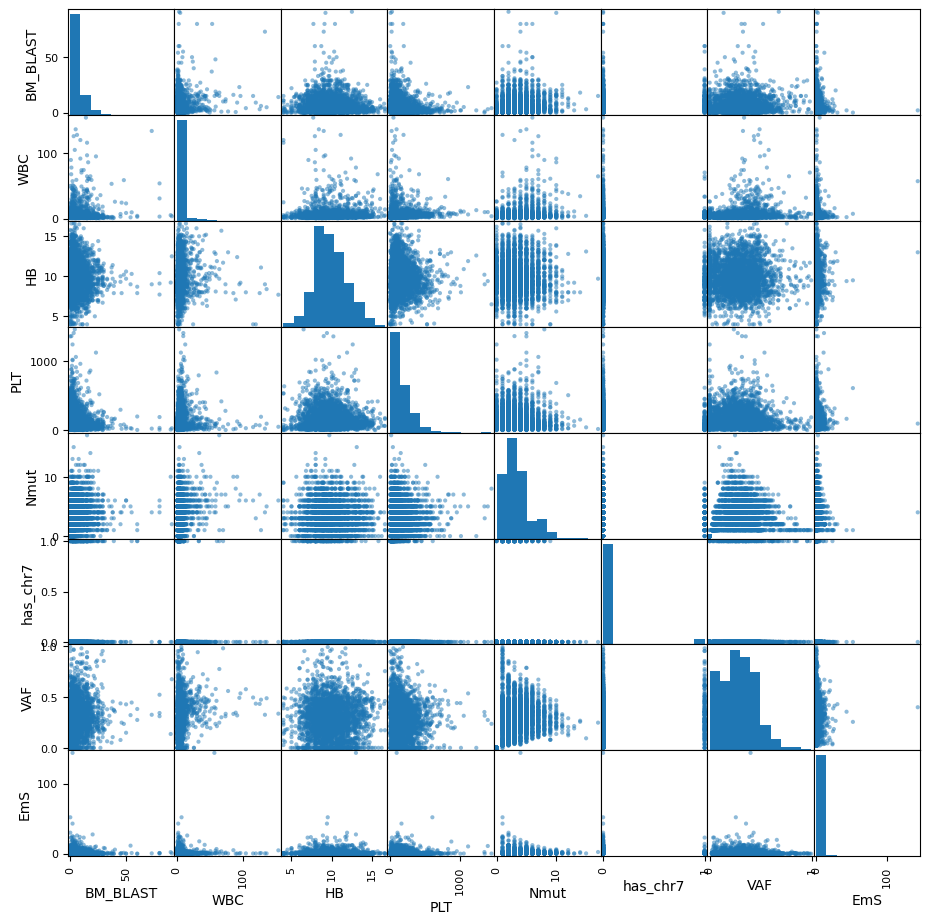

In [12]:
pd.plotting.scatter_matrix(X, figsize=(11, 11))

In [13]:
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm')

,BM_BLAST,WBC,HB,PLT,Nmut,has_chr7,VAF,EmS
BM_BLAST,1.000000,0.101454,-0.049057,-0.218729,0.171543,0.131347,0.126613,-0.009034
WBC,0.101454,1.000000,0.015728,0.017981,0.189522,-0.025912,0.165083,0.058631
HB,-0.049057,0.015728,1.000000,-0.058117,-0.035716,-0.088803,-0.014776,0.016951
PLT,-0.218729,0.017981,-0.058117,1.000000,-0.078955,-0.111185,-0.063453,-0.008958
Nmut,0.171543,0.189522,-0.035716,-0.078955,1.000000,-0.030246,0.192255,0.028664
has_chr7,0.131347,-0.025912,-0.088803,-0.111185,-0.030246,1.000000,0.072298,-0.028289
VAF,0.126613,0.165083,-0.014776,-0.063453,0.192255,0.072298,1.000000,-0.000270
EmS,-0.009034,0.058631,0.016951,-0.008958,0.028664,-0.028289,-0.000270,1.000000


In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Survival-aware imputation for missing values
imputer = SimpleImputer(strategy="median")
X_train[features] = imputer.fit_transform(X_train[features])
X_test[features] = imputer.transform(X_test[features])

In [16]:
import lightgbm as lgb
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv

# Define LightGBM parameters
lgbm_params = {
    'max_depth': 2,
    'learning_rate': 0.05,
    'verbose': -1
}

X_train_lgb = X_train  # Features for training
y_train_transformed = y_train['OS_YEARS']

# Create LightGBM dataset
train_dataset = lgb.Dataset(X_train_lgb, label=y_train_transformed)

# Train the LightGBM model
model = lgb.train(params=lgbm_params, train_set=train_dataset)
# 
# Make predictions on the training and testing sets
pred_train = -model.predict(X_train)
pred_test = -model.predict(X_test)

# Evaluate the model using Concordance Index IPCW
train_ci_ipcw = concordance_index_ipcw(y_train, y_train, pred_train, tau=7)[0]
test_ci_ipcw = concordance_index_ipcw(y_train, y_test, pred_test, tau=7)[0]
print(f"LightGBM Survival Model Concordance Index IPCW on train: {train_ci_ipcw:.2f}")
print(f"LightGBM Survival Model Concordance Index IPCW on test: {test_ci_ipcw:.2f}")

LightGBM Survival Model Concordance Index IPCW on train: 0.71
LightGBM Survival Model Concordance Index IPCW on test: 0.70


### Naive Approach To Incorporating Effect of Protein Change

A database is created with the average survival years given a protein change.
Then the mean can be taken for each patient and used in the regression.

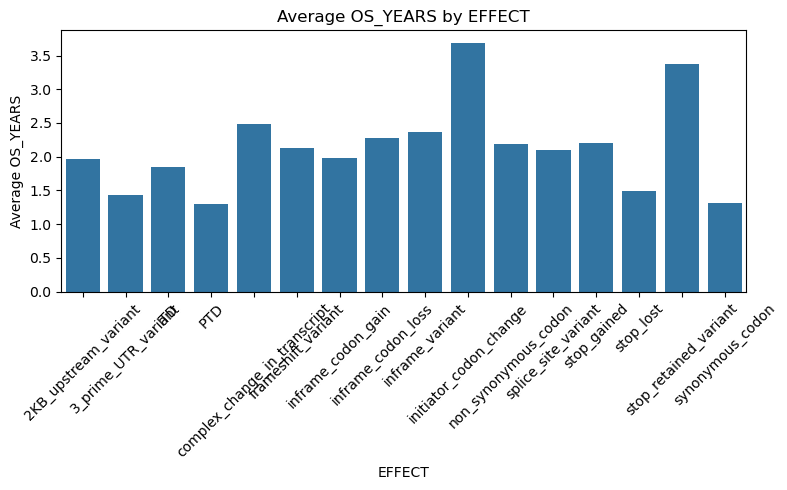

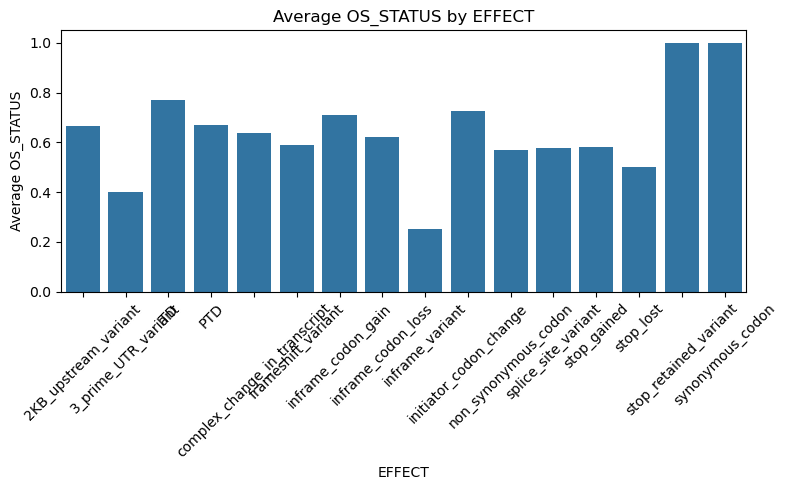

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Merge maf_df (EFFECT) with df_4 (risk_factor) and target_df (OS_YEARS, OS_STATUS) on 'ID'
merged = maf_df[['ID', 'EFFECT']].merge(df_4[['ID']], on='ID', how='left').merge(target_df[['ID', 'OS_YEARS', 'OS_STATUS']], on='ID', how='left')

# b) Histogram of EFFECT and the average OS_YEARS
avg_os_years_by_effect = merged.groupby('EFFECT')['OS_YEARS'].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(x='EFFECT', y='OS_YEARS', data=avg_os_years_by_effect)
plt.title('Average OS_YEARS by EFFECT')
plt.xlabel('EFFECT')
plt.ylabel('Average OS_YEARS')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# b) Histogram of EFFECT and the average OS_STATUS
avg_os_status_by_effect = merged.groupby('EFFECT')['OS_STATUS'].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(x='EFFECT', y='OS_STATUS', data=avg_os_status_by_effect)
plt.title('Average OS_STATUS by EFFECT')
plt.xlabel('EFFECT')
plt.ylabel('Average OS_STATUS')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
merged.head()

,ID,EFFECT,OS_YEARS,OS_STATUS
0,P100000,non_synonymous_codon,5.819178,0.0
1,P100000,stop_gained,5.819178,0.0
2,P100000,splice_site_variant,5.819178,0.0
3,P100000,non_synonymous_codon,5.819178,0.0
4,P100000,frameshift_variant,5.819178,0.0


In [19]:
id_effect_avg = maf_df[['ID', 'EFFECT']].merge(avg_os_years_by_effect, on='EFFECT', how='left')
id_effect_avg = id_effect_avg.groupby('ID')['OS_YEARS'].min().reset_index().rename(columns={'OS_YEARS': 'EFFECT_PROTEIN_CHANGE'})
id_effect_avg.head()

,ID,EFFECT_PROTEIN_CHANGE
0,P100000,2.105833
1,P100001,2.192573
2,P100002,2.192573
3,P100004,2.131050
4,P100006,2.131050


In [20]:
full_pred = -model.predict(df_4[features])
new_col = pd.Series(full_pred, index=df_4['ID'], name='risk_score')
df_5 = pd.merge(df_4, new_col, on='ID')
df_6 = pd.merge(df_5, id_effect_avg, on='ID', how='left')

features2 = ['WBC', 'risk_score', 'EFFECT_PROTEIN_CHANGE']
X2 = df_6.loc[df_6['ID'].isin(target_df['ID']), features2]

array([[<Axes: xlabel='WBC', ylabel='WBC'>,
        <Axes: xlabel='risk_score', ylabel='WBC'>,
        <Axes: xlabel='EFFECT_PROTEIN_CHANGE', ylabel='WBC'>,
        <Axes: xlabel='OS_YEARS', ylabel='WBC'>,
        <Axes: xlabel='OS_STATUS', ylabel='WBC'>],
       [<Axes: xlabel='WBC', ylabel='risk_score'>,
        <Axes: xlabel='risk_score', ylabel='risk_score'>,
        <Axes: xlabel='EFFECT_PROTEIN_CHANGE', ylabel='risk_score'>,
        <Axes: xlabel='OS_YEARS', ylabel='risk_score'>,
        <Axes: xlabel='OS_STATUS', ylabel='risk_score'>],
       [<Axes: xlabel='WBC', ylabel='EFFECT_PROTEIN_CHANGE'>,
        <Axes: xlabel='risk_score', ylabel='EFFECT_PROTEIN_CHANGE'>,
        <Axes: xlabel='EFFECT_PROTEIN_CHANGE', ylabel='EFFECT_PROTEIN_CHANGE'>,
        <Axes: xlabel='OS_YEARS', ylabel='EFFECT_PROTEIN_CHANGE'>,
        <Axes: xlabel='OS_STATUS', ylabel='EFFECT_PROTEIN_CHANGE'>],
       [<Axes: xlabel='WBC', ylabel='OS_YEARS'>,
        <Axes: xlabel='risk_score', ylabel='OS_YEARS'>,

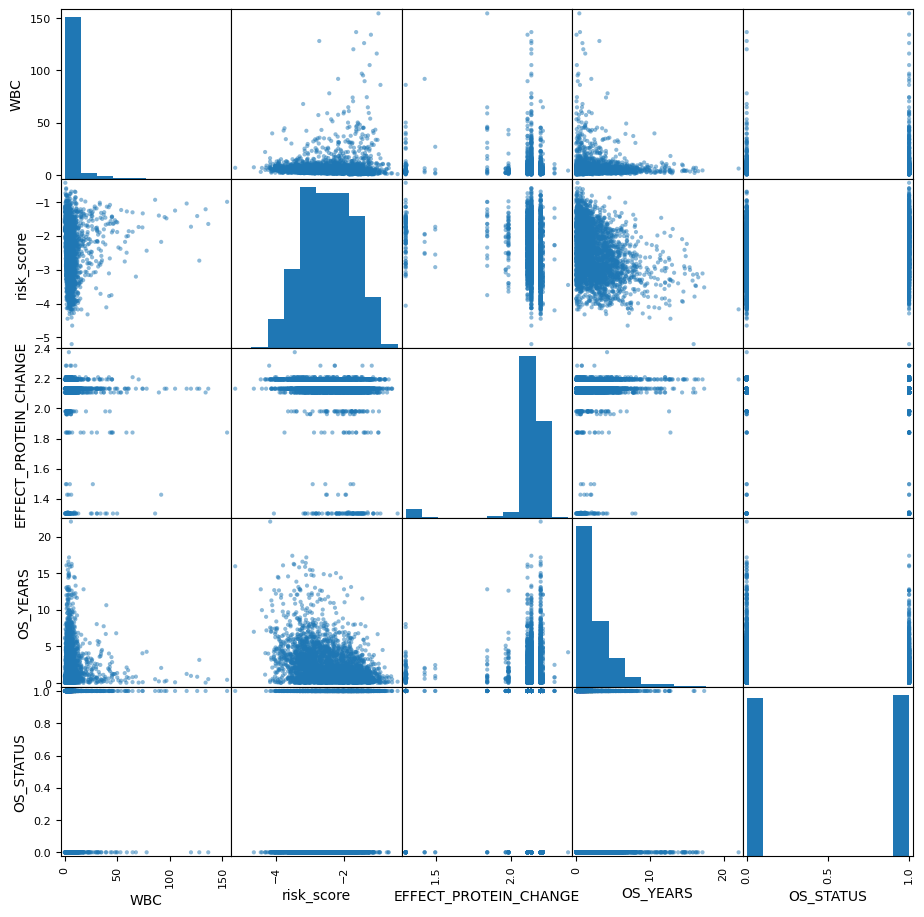

In [21]:
X3 = pd.merge(df_6, target_df, on='ID', how='left')
X3 = X3[features2 + ['OS_YEARS', 'OS_STATUS']]
pd.plotting.scatter_matrix(X3, figsize=(11, 11))

In [22]:
corr = X2.corr()
corr.style.background_gradient(cmap='coolwarm')

,WBC,risk_score,EFFECT_PROTEIN_CHANGE
WBC,1.000000,0.095090,-0.079852
risk_score,0.095090,1.000000,-0.171373
EFFECT_PROTEIN_CHANGE,-0.079852,-0.171373,1.000000


In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, random_state=45)

In [24]:
imputer = SimpleImputer(strategy="median")
X_train[features2] = imputer.fit_transform(X_train[features2])
X_test[features2] = imputer.transform(X_test[features2])

In [25]:
# Initialize and train the Cox Proportional Hazards model

cox = CoxPHSurvivalAnalysis(alpha=1.0, ties='efron', n_iter=1000, tol=1e-12, verbose=True)
cox.fit(X_train, y_train)

train = cox.predict(X_train)
test = cox.predict(X_test)

# Evaluate the model using Concordance Index IPCW
cox_cindex_train = concordance_index_ipcw(y_train, y_train, train, tau=7)[0]
cox_cindex_test = concordance_index_ipcw(y_train, y_test, test, tau=7)[0]
print(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox_cindex_train:.2f}")
print(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox_cindex_test:.2f}")

iter      6: optimization converged
Cox Proportional Hazard Model Concordance Index IPCW on train: 0.70
Cox Proportional Hazard Model Concordance Index IPCW on test: 0.70


### Inference on test set

In [26]:
# For df_eval4: create EFFECT->AVG_OS_YEARS mapping and merge into df_eval4
eval_effect_avg = maf_eval[['ID', 'EFFECT']].merge(avg_os_years_by_effect, on='EFFECT', how='left')
eval_effect_avg = eval_effect_avg.groupby('ID')['OS_YEARS'].mean().reset_index().rename(columns={'OS_YEARS': 'EFFECT_PROTEIN_CHANGE'})
df_eval4 = pd.merge(df_eval4, eval_effect_avg, on='ID', how='left')
df_eval4.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS,has_chr7,Nmut,VAF,START,END,EmS,EFFECT_PROTEIN_CHANGE
0,KYW1,KYW,68.0,3.45,0.5865,NaN,7.6,48.0,"47,XY,+X,del(9)(q?)[15]/47,XY,+X[5]",0,4.0,0.246225,1.168689e+08,1.168689e+08,0.000000,2.092683
1,KYW2,KYW,35.0,3.18,1.2402,NaN,10.0,32.0,"46,XY,der(3)?t(3;11)(q26.2;q23),add(4)(p15).de...",0,3.0,0.281000,8.935960e+07,8.935960e+07,0.000000,2.197439
2,KYW3,KYW,NaN,12.40,8.6800,NaN,12.3,25.0,"47,XX,+8",0,3.0,0.162667,5.606792e+07,5.606792e+07,0.333333,2.181797
3,KYW4,KYW,61.0,5.55,2.0535,NaN,8.0,44.0,Normal,0,3.0,0.351367,3.433546e+07,3.433546e+07,0.000000,2.059386
4,KYW5,KYW,2.0,1.21,0.7381,NaN,8.6,27.0,"43,XY,dic(5;17)(q11.2;p11.2),-7,-13,-20,-22,+r...",0,3.0,0.263667,4.475948e+07,4.475948e+07,0.000000,2.202305


In [27]:
nn_pred = -model.predict(df_eval4[features])
new_col = pd.Series(nn_pred, index=df_eval4['ID'], name='risk_score')
df_eval4 = pd.merge(df_eval4, new_col, on='ID')

In [28]:
df_eval4[features2] = imputer.transform(df_eval4[features2])

In [29]:
df_eval4.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS,has_chr7,Nmut,VAF,START,END,EmS,EFFECT_PROTEIN_CHANGE,risk_score
0,KYW1,KYW,68.0,3.45,0.5865,NaN,7.6,48.0,"47,XY,+X,del(9)(q?)[15]/47,XY,+X[5]",0,4.0,0.246225,1.168689e+08,1.168689e+08,0.000000,2.092683,-1.547422
1,KYW2,KYW,35.0,3.18,1.2402,NaN,10.0,32.0,"46,XY,der(3)?t(3;11)(q26.2;q23),add(4)(p15).de...",0,3.0,0.281000,8.935960e+07,8.935960e+07,0.000000,2.197439,-1.588073
2,KYW3,KYW,NaN,12.40,8.6800,NaN,12.3,25.0,"47,XX,+8",0,3.0,0.162667,5.606792e+07,5.606792e+07,0.333333,2.181797,-2.511163
3,KYW4,KYW,61.0,5.55,2.0535,NaN,8.0,44.0,Normal,0,3.0,0.351367,3.433546e+07,3.433546e+07,0.000000,2.059386,-1.336243
4,KYW5,KYW,2.0,1.21,0.7381,NaN,8.6,27.0,"43,XY,dic(5;17)(q11.2;p11.2),-7,-13,-20,-22,+r...",0,3.0,0.263667,4.475948e+07,4.475948e+07,0.000000,2.202305,-1.583718


In [30]:
prediction_on_test_set = cox.predict(df_eval4.loc[:, features2])

In [31]:
if min(prediction_on_test_set) < 0:
    prediction_on_test_set = prediction_on_test_set - min(prediction_on_test_set)+0.01
prediction_on_test_set = prediction_on_test_set/max(prediction_on_test_set)

In [32]:
submission = pd.Series(prediction_on_test_set, index=df_eval['ID'], name='risk_score')

In [33]:

submission.to_csv('./ProtChange_submission.csv')

In [34]:
submission

ID
KYW1       0.507861
KYW2       0.491800
KYW3       0.325022
KYW4       0.553678
KYW5       0.489988
             ...   
KYW1189    0.404542
KYW1190    0.417355
KYW1191    0.357023
KYW1192    0.406085
KYW1193    0.404542
Name: risk_score, Length: 1193, dtype: float64